### Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow            as tf
import tensorflow.keras      as keras
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.layers import MaxPooling2D, AvgPool2D, InputLayer, Dropout, Flatten, Dense
import matplotlib.pyplot     as plt
import pandas                as pd

import skimage
import skimage.transform

In [3]:
import sys
sys.path.append('../utilities/')
from utilities import Timer, show_image, DreamImage, DeepDream

## Model

In [4]:
# Load the classnames
df = pd.read_excel('../dataset/artist-breakdown-annotated.xlsx')
df = df[df.fillna(0).keep.astype(bool)]
class_names = df.artist.unique()
class_names.sort()

In [5]:
width = height = 224

# Load the model
model_name = 'vgg19-INet-down2-b'
base_model = load_model(f'../classification/logs/models/{model_name}.hdf5')

dream_model = Sequential([InputLayer(input_shape = (width, height, 3))])
for layer in base_model.layers[:-1]:
    # Replace max pool with average pool to promote gradient flow
    if isinstance(layer, MaxPooling2D):
        pool = AvgPool2D().from_config(layer.get_config())
        dream_model.add(pool)
    elif isinstance(layer, Dropout):
        pass
    else:
        dream_model.add(layer)
    
# Add the top layer without softmax
top_config = base_model.layers[-1].get_config()
top_config['activation'] = 'relu'
top_layer = base_model.layers[-1].from_config(top_config)
dream_model.add(top_layer)

dream_model.build()

dreamer = DeepDream(dream_model)

In [6]:
# Load the image
image_path = '../dream-base-images/marco3.png'

marco   = DreamImage(image_path, width, height)

In [7]:
# Most similar artist beforehand
class_names[dream_model(marco.prepare_base()).numpy().argmax()]

'Georges Seurat'

[==================================================] 100/100 ETA:  1.2s per loops          


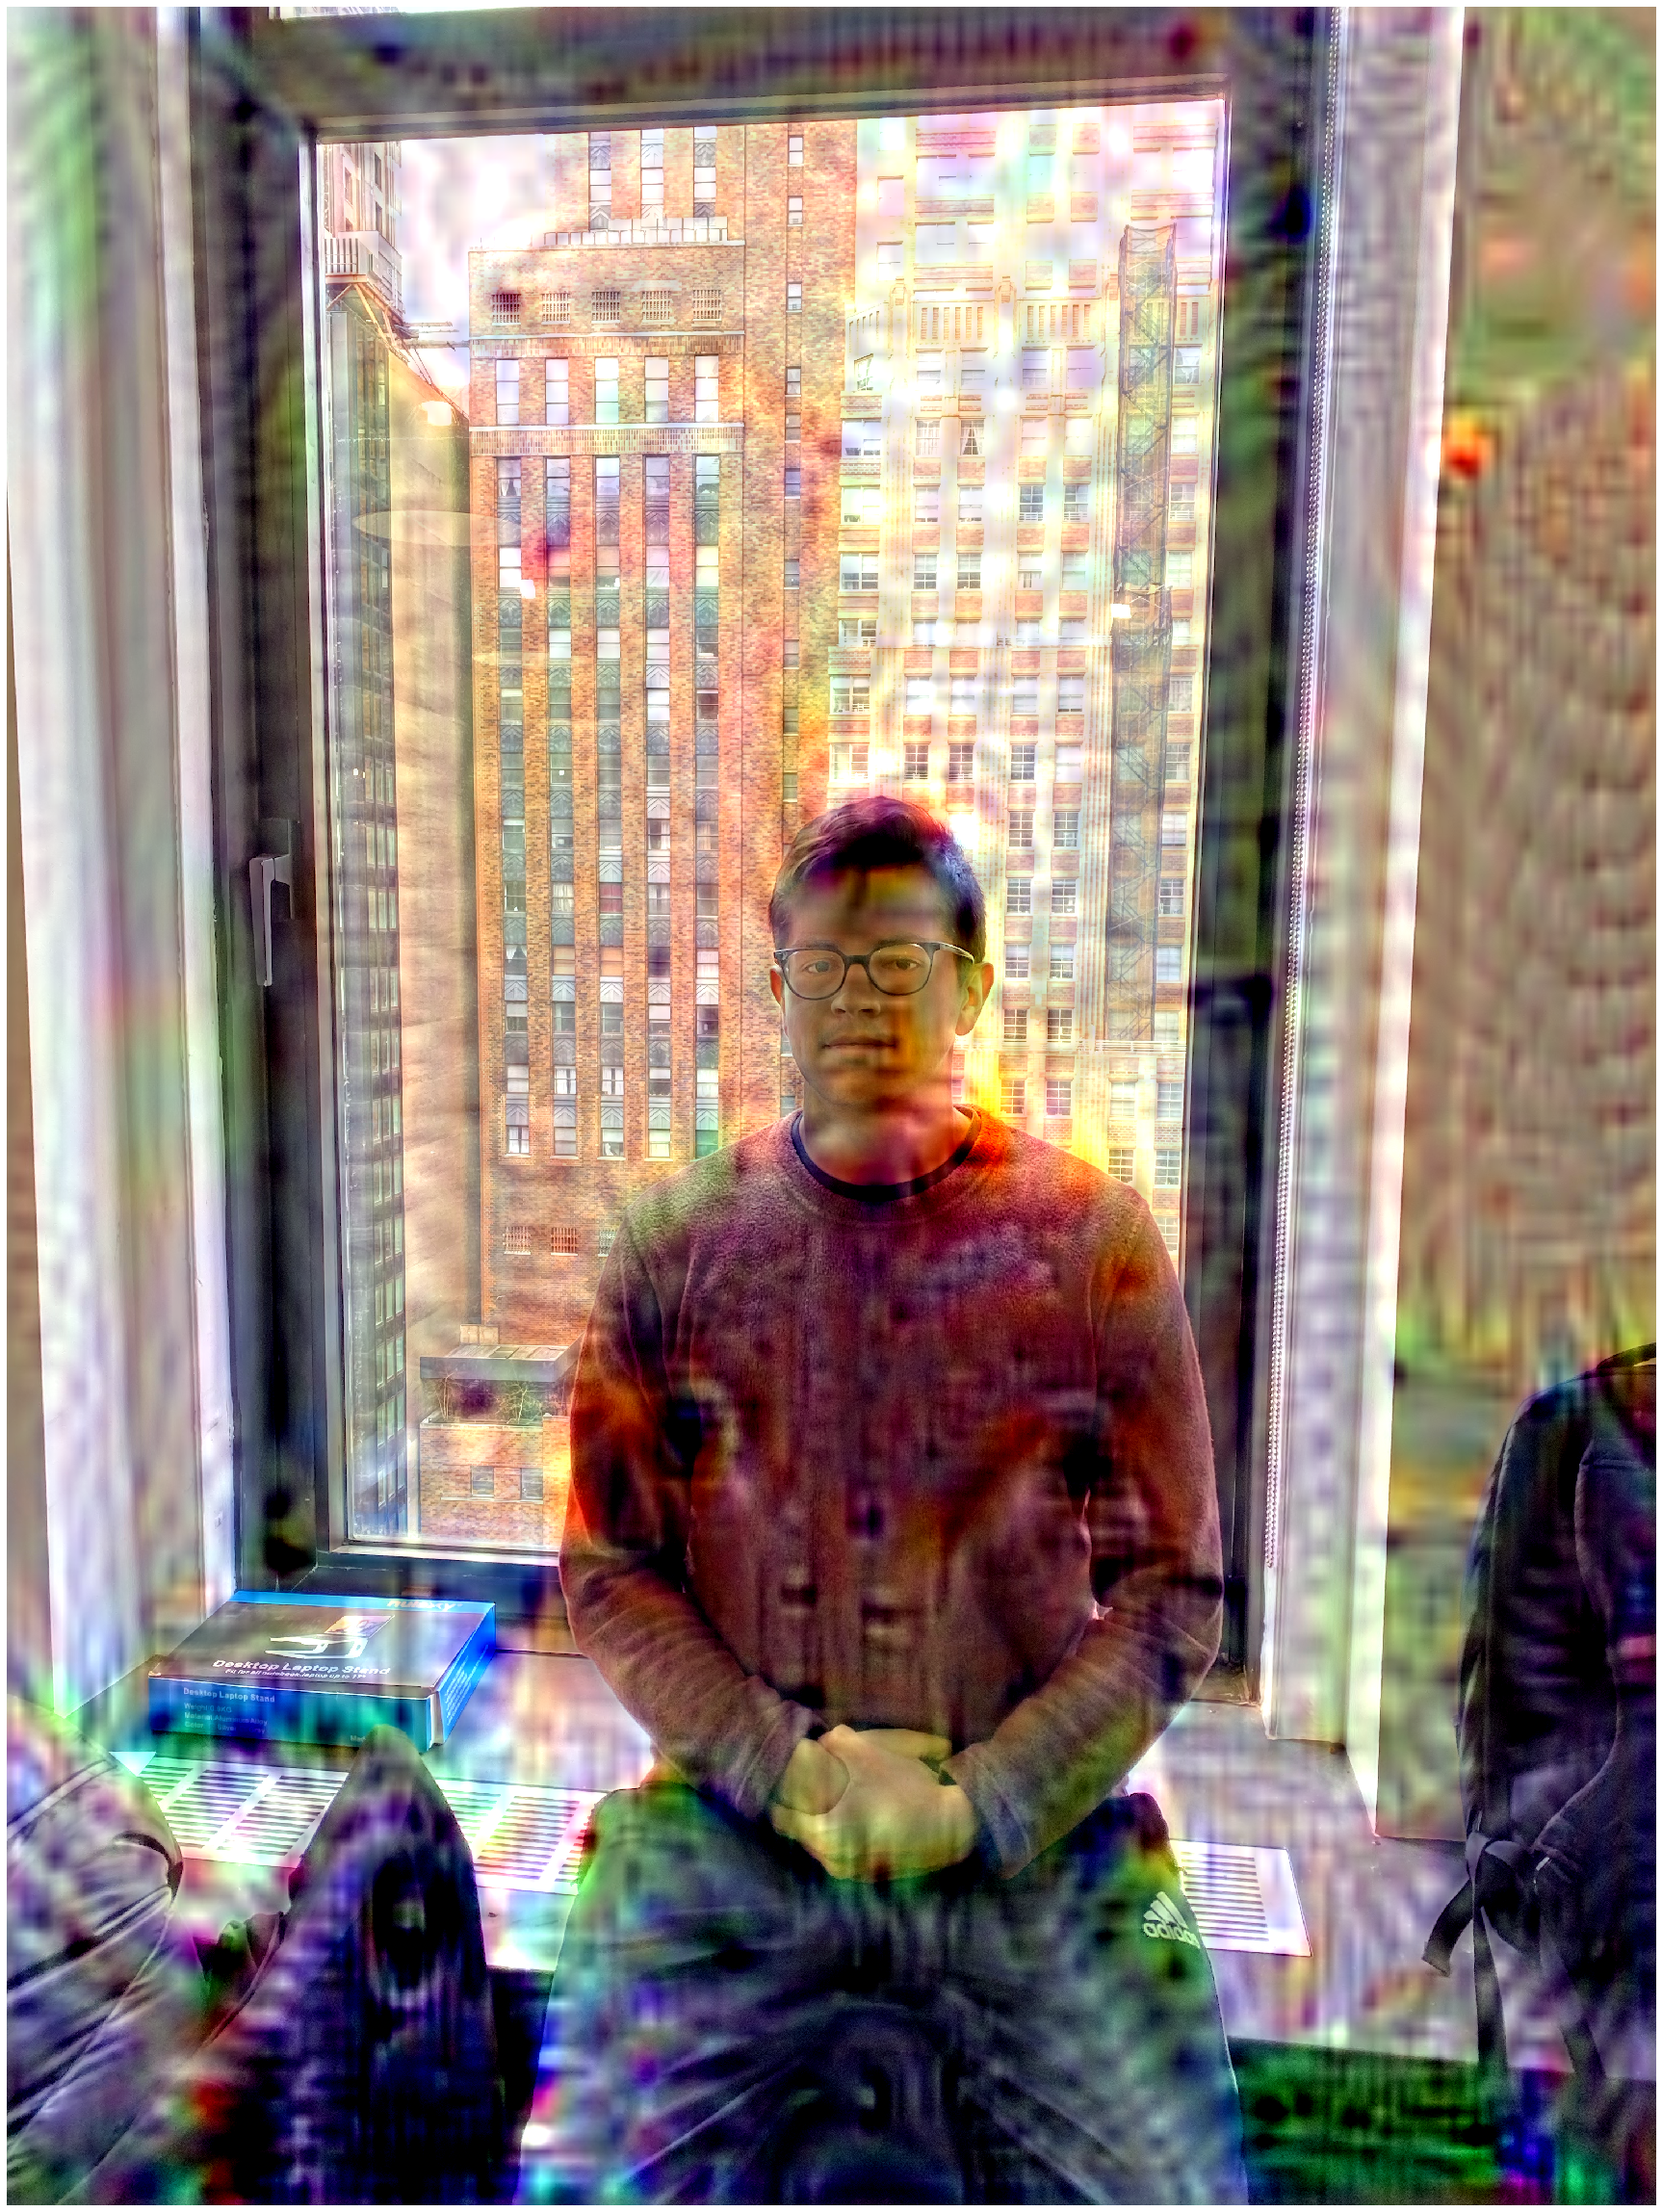

In [8]:
dream, steps = dreamer.run_deep_dream_simple(marco.prepare_base())
marco.show_dream(dream, full_size = True)

In [ ]:
import numpy as np
np.array(steps).shape